In [1]:
import os
import sys
from pathlib import Path

cwd = Path(os.getcwd())
sys.path.append(str(cwd.parent)+'/src/')

import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget

import geometric_objects as geomObj
import geometry as geom

In [3]:
# CONVENIENCE FUNCTIONS FOR TESTING

def sphere(phi:float,theta:float,R:float=1.0):
    x, y, z = R*np.sin(theta)*np.cos(phi), R*np.sin(theta)*np.sin(phi), R*np.cos(theta)
    return x,y,z

def cylinder(phi:float,z:float,R:float=1):
    X, Y, Z = R*np.cos(phi), R*np.sin(phi), R*z
    return X, Y, Z
   
def plot_nbrhd(cloud,idx,k:int=15):
  
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(cloud)
    _, indices = nbrs.kneighbors(cloud)

    point = cloud[idx]
    neighbours = cloud[indices[idx]]

    normal, _, _ = pca_analysis(point, neighbours)

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], color='blue', alpha=0.1)
    ax.scatter(neighbours[:, 0], neighbours[:, 1], neighbours[:, 2], color='red', s=10) # NBRS OF p
    ax.scatter(point[0], point[1], point[2], color='green', s=20)  # p

    # PLOT NORMAL AS ARROW 
    ax.quiver(
        point[0], point[1], point[2], # START POINT OF VECTOR
        normal[0] , normal[1], normal[2], # DIRECTION
        color = 'red', alpha = 1, lw = 2,
    )

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    plt.tight_layout()
    plt.show()
    
def plot_surf(surf):
    """
    vertices = list of np.arrays = pts
    """
    
    vertices_ = np.array(surf[0])

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(vertices_[:, 0], vertices_[:, 1], vertices_[:, 2], color='blue')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    plt.tight_layout()
    plt.show()

def get_interior_pts_idx(vertices:Vertices,face:Face,n:int=2):
    idx0, idx1, idx2 = face
    v0, v1, v2 = vertices[idx0], vertices[idx1], vertices[idx2]
    is_old = False

    vertices_idx = []

    # FIND VERTICES
    for i in range(0,n+1):
        # GET POINT ON EDGE v0-v1 AND DEFINE LINE TO CORRESPONDING POINT ON EDGE v0-v2
        p1 = v0 + (i / n) * (v1 - v0) 
        p2 = v0 + (i / n) * (v2 - v0) 

        # ith LINE HAS TWO POINTS ON THE OUTER EDGES AND i POINTS ON THE LINE CONNECTING THOSE POINTS
        for j in range(i+1):
            if i > 0:
                p = p1 + (j/i)*(p2-p1)
            else:
                p = p1
            
            # CHECK IF ALREADY IN VERTICES
            for idx, v in enumerate(vertices):
                if np.allclose(p, v, atol=1e-8): # CHECKS (UP TO TOLERANCE IF TWO ELEMENTS ARE THE SAME)
                    vertices_idx.append(idx) # IF p ALREADY IN vertices, RETURN ITS INDEX
                    is_old = True
                
            if not is_old:
                # IF p IS NOT IN vertices, NORMALISE (TO LIE ON SPHERE), ADD IT AND RETURN ITS INDEX
                vertices.append(p) #/np.linalg.norm(p)
                vertices_idx.append(len(vertices)-1)
            
            is_old = False
   

    return vertices_idx
       
def get_edges_and_faces(vertices_idx:list[int]):
    lines = []
    vertices_ = vertices_idx.copy()
    edges_ = set()
    faces_ = set()
    n = int(1/2 * (-1 + np.sqrt(8 *len(vertices_) + 1)) - 1)  # INVERSE TRIANGULAR NUMBER, ZERO-BASED
    for k in range(1,n+2):
        lines.append(vertices_[:k])
        del vertices_[:k]

    for k in range(len(lines)-1):
        for i in range(k+1):
            e1 = tuple(sorted([lines[k][i],lines[k+1][i]]))
            e2 = tuple(sorted([lines[k][i],lines[k+1][i+1]]))
            e3 = tuple(sorted([lines[k+1][i],lines[k+1][i+1]]))

            f = {tuple(sorted([lines[k][i],lines[k+1][i],lines[k+1][i+1]]))}
            if (k > 0) & (i < k):
                f.update({tuple(sorted([lines[k][i],lines[k][i+1],lines[k+1][i+1]]))})
            

            edges_.update({e1,e2,e3})
            faces_.update(f)
            
    return edges_, faces_


### Icosphere

In [4]:
n = 3
icosphere = geomObj.Icosphere(n_subdivision=n)

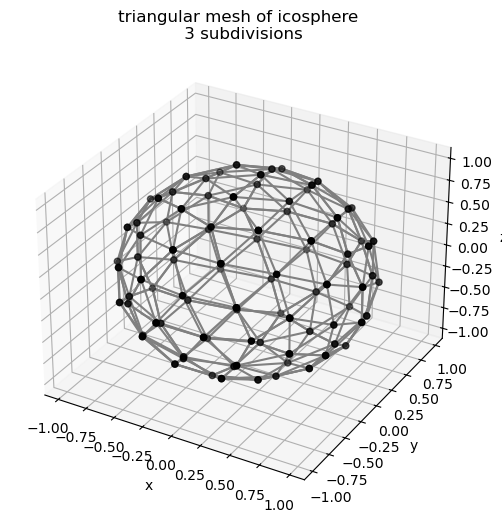

In [5]:
icosphere.plot_mesh(v_color='k',e_color='gray',title=f'triangular mesh of icosphere \n {n} subdivisions')

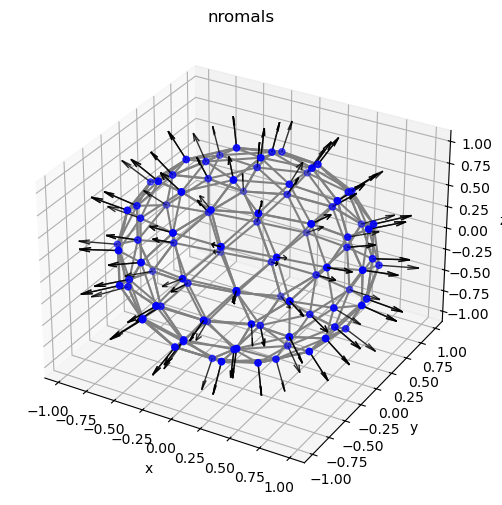

In [7]:
icosphere.plot_normals(scale=0.3,title='nromals',mesh=True)

### Cylinder

In [9]:
cylinder = geomObj.Cylinder(steps=5)

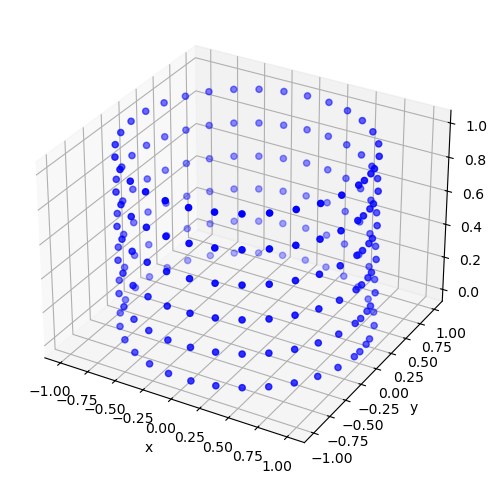

In [10]:
cylinder.plot_surface()

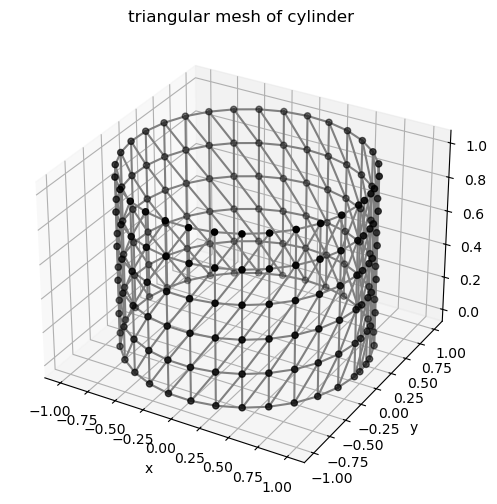

In [11]:
cylinder.plot_mesh(v_color='k',e_color='gray',title=f'triangular mesh of cylinder')

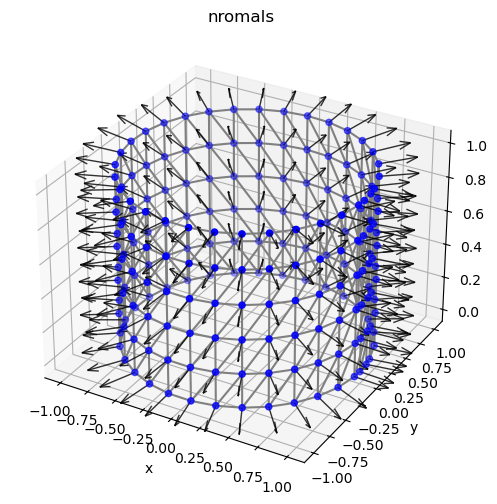

In [12]:
cylinder.plot_normals(scale=0.3,title='nromals',mesh=True)

Note: uniform sampling done by uniform sampling the rectangle $[0,2\pi] \times [0,1] $ in $\mathbb{R}^2$ and then rolling it up (via prametrisation) into a cylinder.

It would be interesting to try out other uniform grids, for example honeycone!

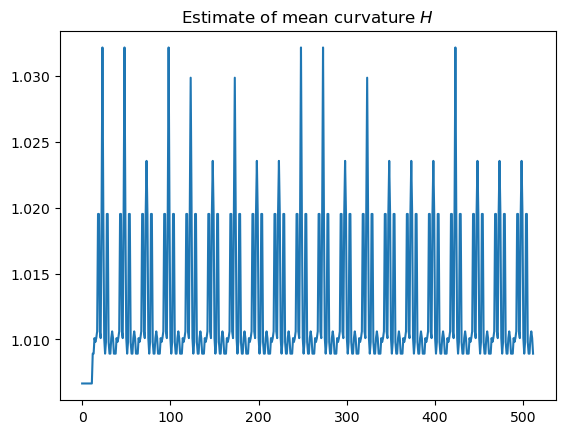

In [13]:
# EXAMPLE SPHERE


# S2 = np.array([X.ravel(),Y.ravel(),Z.ravel()]).T

icosphere = geomObj.Icosphere(n_subdivision=6)

S2 = np.array(icosphere.surf[0])

curv = geom.mean_curv(S2,k=10)

H = np.array([F for _, F in curv])

plt.plot(H)
plt.title(r'Estimate of mean curvature $H$')
plt.show()


# MISC

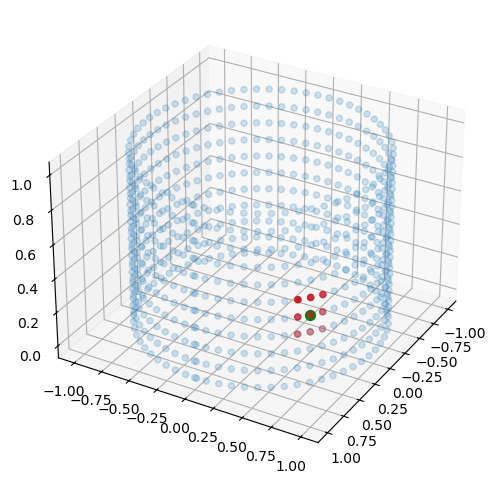

In [36]:
# NEIGHBORHOOD OF POINT

# UNIFORM RECTANGULAR GRID OF [0,2PI] X [0,1] 
steps = 10
step_size = 1 / steps
phi = np.arange(0,2*np.pi + step_size,step_size)
z = np.arange(0,1 + step_size,step_size)

phi,z  = np.meshgrid(phi,z)

# DEFINE CLOUD OF POINTS
points = np.array([phi.ravel(),z.ravel()]).T


# COMPUTE KNN INSIDE THE RECTANGLE
k = 9

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(points)
distances, indices = nbrs.kneighbors(points)

n = 265

neighbors = points[indices[n]]
point = points[n]

# MAP TO CYLINDER
X,Y,Z = cylinder(phi,z)                                 # cloud of points on cylinder
pX,pY,pZ = cylinder(point[0],point[1])                  # fixed point p
nX, nY, nZ = cylinder(neighbors[:,0],neighbors[:,1])    # neighbours of p 


# PLOT
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X,Y,Z,alpha=0.2)
ax.scatter(nX,nY,nZ,color='r')
ax.scatter(pX,pY,pZ,color='g',s=50)

ax.view_init(elev=30, azim=30, roll=0)

plt.show()

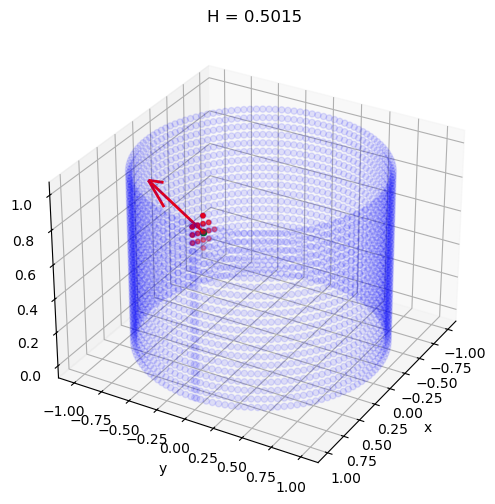

KeyboardInterrupt: 

In [9]:
# "VIDEO" NORMAL VECTOR MOVING AROUND CYLINDER AND MEAN CURVATURE

# UNIFORM RECTANGULAR GRID OF [0,2PI] X [0,1] 
steps = 20
step_size = 1 / steps
phi = np.arange(0,2*np.pi + step_size,step_size)
z = np.arange(0,1 + step_size,step_size)

phi,z  = np.meshgrid(phi,z)

# CLOUD OF POINTS
points = np.array([phi.ravel(),z.ravel()]).T

# MAP TO CYLINDER
X,Y,Z = cylinder(phi,z)  # cloud of points on cylinder 

# COMPUTE KNN INSIDE THE RECTANGLE
k = 15

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(points)
distances, indices = nbrs.kneighbors(points)

# CLOUD OF POINTS ON CYLINDER (UNIFORM)
XYZ = np.array([X.ravel(),Y.ravel(),Z.ravel()]).T 

for i in range(0,100):
    n = 800 + 3*i # "VIDEO FRAME"

    neighbors = points[indices[n]]
    point = points[n]                   

    pX,pY,pZ = cylinder(point[0],point[1])                  # fixed point p             
    nX, nY, nZ = cylinder(neighbors[:,0],neighbors[:,1])    # neighbours of p 
    
    point_on_cyl = np.array([pX,pY,pZ])
    neighbors_on_cyl = np.vstack([nX,nY,nZ]).T

    normal, e1, e2 = pca_analysis(point_on_cyl, neighbors_on_cyl)

    kappa1, kappa2 = estimate_principal_curvatures(point_on_cyl, neighbors_on_cyl)

    H = (kappa1 + kappa2) / 2 # kappa1 = 0, kappa2 = 1 / (2R)
    

    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], color='blue', alpha=0.1)
    ax.scatter(neighbors_on_cyl[:, 0], neighbors_on_cyl[:, 1], neighbors_on_cyl[:, 2], color='red', s=10) # NBRS OF p
    ax.scatter(pX, pY, pZ, color='green', s=20)  # p

    # PLOT NORMAL AS ARROW 
    ax.quiver(
        pX, pY, pZ, # START POINT OF VECTOR
        normal[0] , normal[1], normal[2], # DIRECTION
        color = 'red', alpha = 1, lw = 2,
    )

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(f'H = {H:.4f}')

    ax.view_init(elev=30, azim=30, roll=0)


    display.display(plt.gcf())
    display.clear_output(wait=True)

    plt.show()

